#2024 MLB Player Performance Analyses

###Import Libraries

In [75]:
from pybaseball import batting_stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

###Import 2024 Batter Stats

In [76]:
# Batters stats for 2024 Season
batting_2024 = batting_stats(2024)

# Filtering with > 100 at-bats
batting_2024 = batting_2024[batting_2024['AB'] > 100]

print(batting_2024.head())
print(batting_2024.columns)
print(batting_2024.info())
print(batting_2024.describe())

    IDfg  Season              Name Team  Age  ...   CSW%    xBA   xSLG  xwOBA  L-WAR
0  15640    2024       Aaron Judge  NYY   32  ...  0.267  0.310  0.723  0.479   11.4
3  25764    2024    Bobby Witt Jr.  KCR   24  ...  0.236  0.315  0.577  0.407   10.4
1  19755    2024     Shohei Ohtani  LAD   29  ...  0.269  0.314  0.660  0.442    9.2
2  20123    2024         Juan Soto  NYY   25  ...  0.263  0.316  0.646  0.462    7.9
9  26289    2024  Gunnar Henderson  BAL   23  ...  0.265  0.283  0.492  0.374    8.2

[5 rows x 320 columns]
Index(['IDfg', 'Season', 'Name', 'Team', 'Age', 'G', 'AB', 'PA', 'H', '1B',
       ...
       'maxEV', 'HardHit', 'HardHit%', 'Events', 'CStr%', 'CSW%', 'xBA',
       'xSLG', 'xwOBA', 'L-WAR'],
      dtype='object', length=320)
<class 'pandas.core.frame.DataFrame'>
Index: 129 entries, 0 to 122
Columns: 320 entries, IDfg to L-WAR
dtypes: float64(262), int64(54), object(4)
memory usage: 323.5+ KB
None
               IDfg  Season         Age  ...        xSLG       

##Data Cleaing

In [77]:
# Drop irrelevant columns
batting_2024 = batting_2024.drop(columns=['Season', 'IDfg'], errors='ignore')

###Feature Extraction

In [78]:
# SO rate
batting_2024['SO_rate'] = batting_2024['SO'] / batting_2024['AB']

# BB rate
batting_2024['BB_rate'] = batting_2024['BB'] / batting_2024['AB']

# Power Score
batting_2024['Power Score'] = 0.5 * batting_2024['HR'] + 0.5 * batting_2024['SLG']

print(batting_2024.head())

               Name Team  Age    G  ...  L-WAR   SO_rate   BB_rate  Power Score
0       Aaron Judge  NYY   32  158  ...   11.4  0.305903  0.237925      29.3505
3    Bobby Witt Jr.  KCR   24  161  ...   10.4  0.166667  0.089623      16.2940
1     Shohei Ohtani  LAD   29  159  ...    9.2  0.254717  0.127358      27.3230
2         Juan Soto  NYY   25  157  ...    7.9  0.206597  0.223958      20.7845
9  Gunnar Henderson  BAL   23  159  ...    8.2  0.252381  0.123810      18.7645

[5 rows x 321 columns]


##Visualizations

###HR Distribution

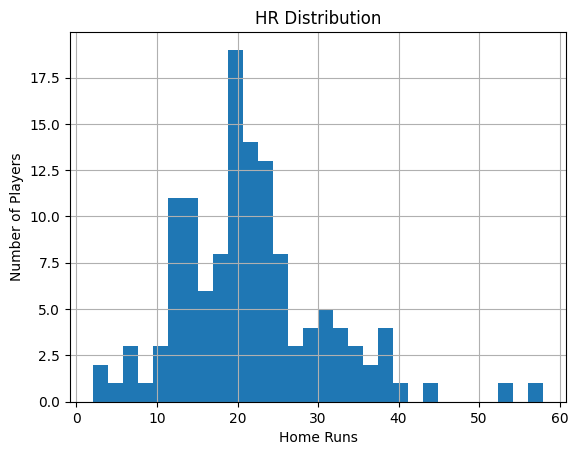

In [79]:
# Home Run Distribution Histogram
batting_2024['HR'].hist(bins = 30)
plt.title('HR Distribution')
plt.xlabel('Home Runs')
plt.ylabel('Number of Players')
plt.show()

###OPS Distribution

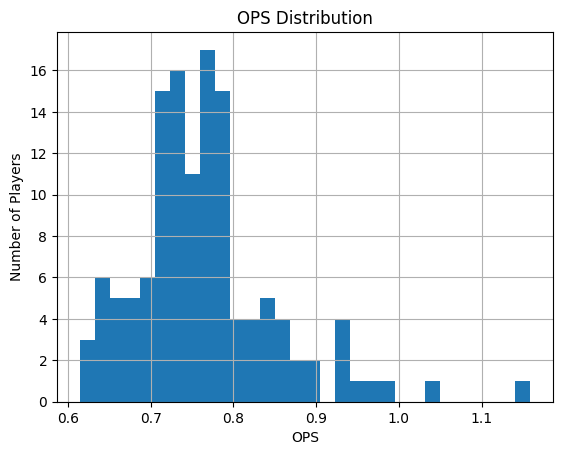

In [80]:
# OPS Distrubution Histogram
batting_2024['OPS'].hist(bins = 30)
plt.title('OPS Distribution')
plt.xlabel('OPS')
plt.ylabel('Number of Players')
plt.show()

###Correlation Heatmap

<function matplotlib.pyplot.show(close=None, block=None)>

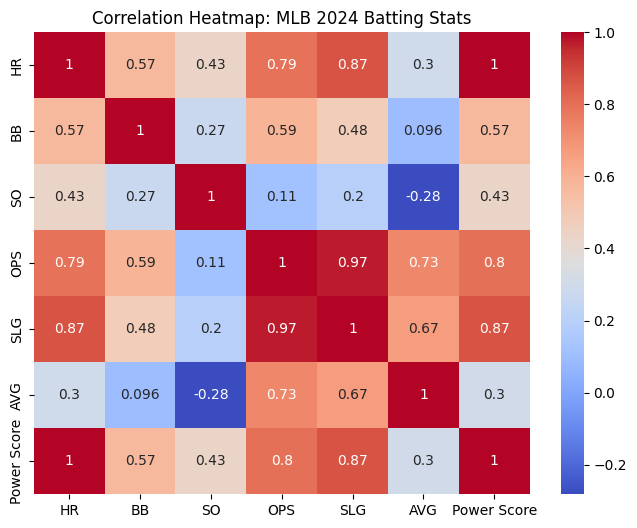

In [81]:
# Correlation Heatmap
corr = batting_2024[['HR', 'BB', 'SO', 'OPS', 'SLG', 'AVG', 'Power Score']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap = 'coolwarm')
plt.title('Correlation Heatmap: MLB 2024 Batting Stats')
plt.show

###Scatter Plot for Correlated Features

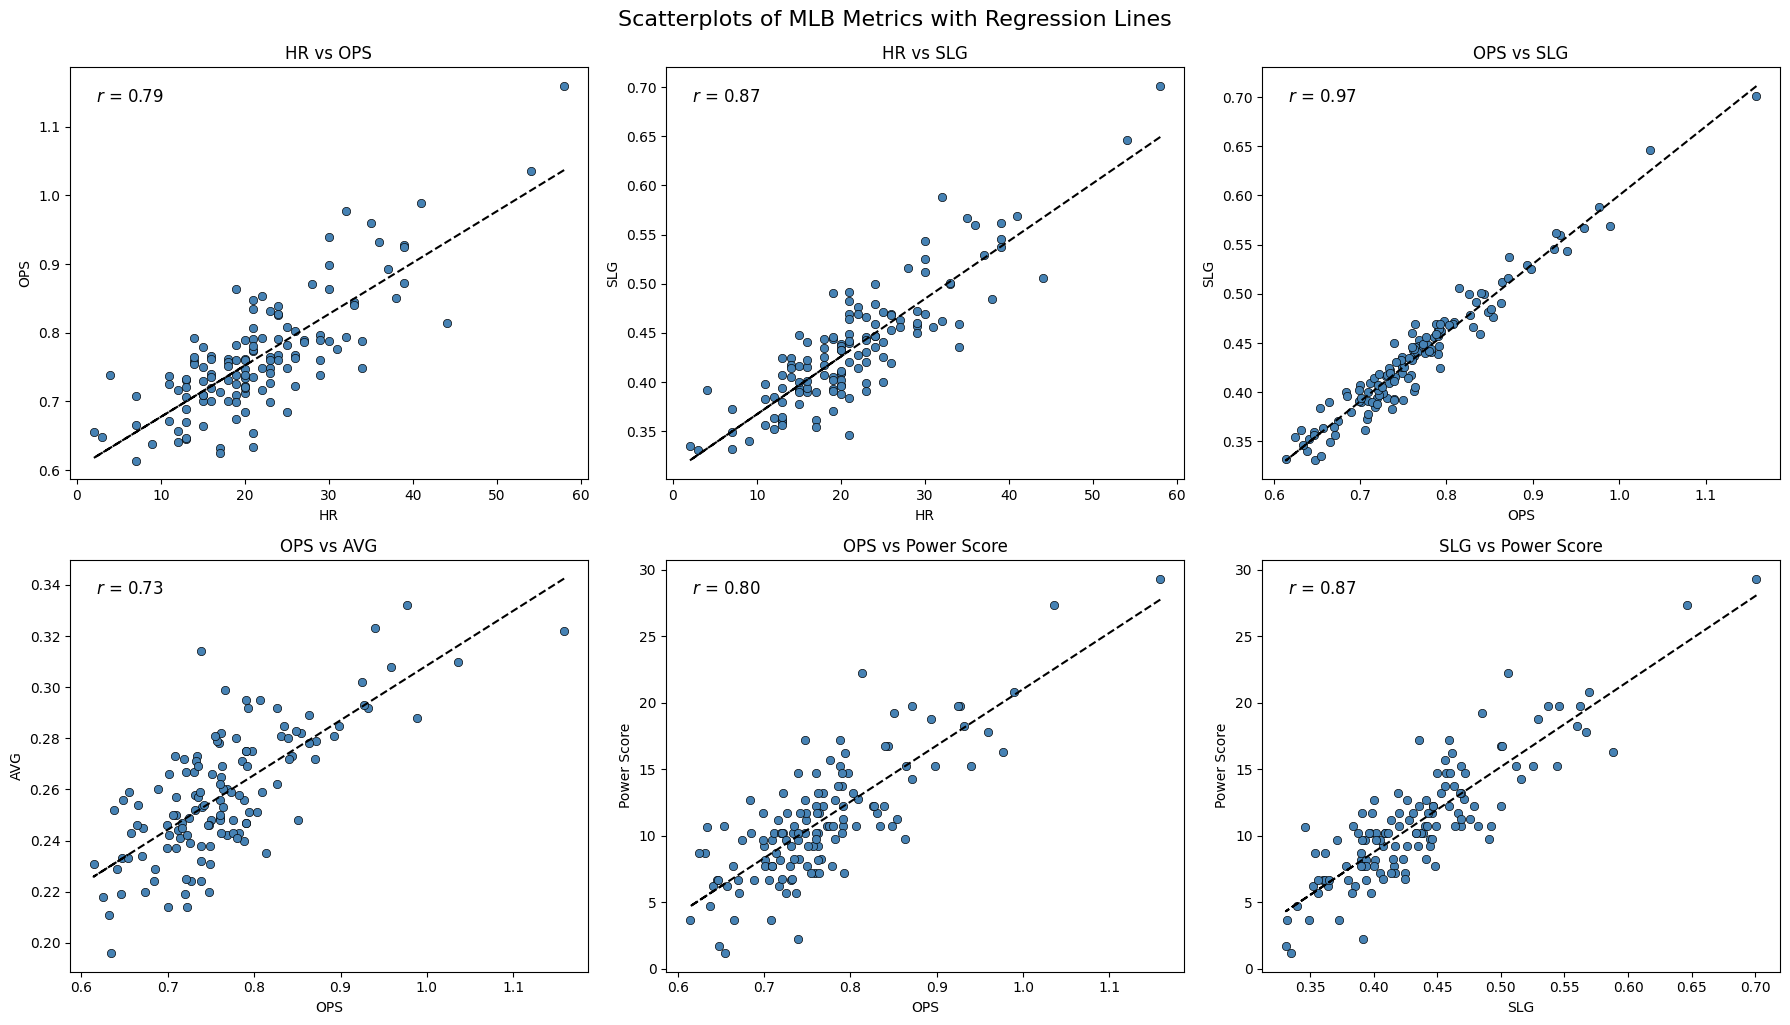

In [82]:
# Correlated features with (r > 0.70)
plots = [
    ('HR', 'OPS'),
    ('HR', 'SLG'),
    ('OPS', 'SLG'),
    ('OPS', 'AVG'),
    ('OPS', 'Power Score'),
    ('SLG', 'Power Score')
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for ax, (x, y) in zip(axes.ravel(), plots):
    sns.scatterplot(data=batting_2024, x=x, y=y, ax=ax, color='steelblue', edgecolor='black')

    slope, intercept, r_value, p_value, _ = linregress(batting_2024[x], batting_2024[y])
    ax.plot(batting_2024[x], intercept + slope * batting_2024[x], color='black', linestyle='--')

    ax.text(0.05, 0.95, f'$r$ = {r_value:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')

    ax.set_title(f'{x} vs {y}')

plt.tight_layout()
plt.suptitle("Scatterplots of MLB Metrics with Regression Lines", fontsize=16, y=1.02)
plt.show()

###Average Team OPS

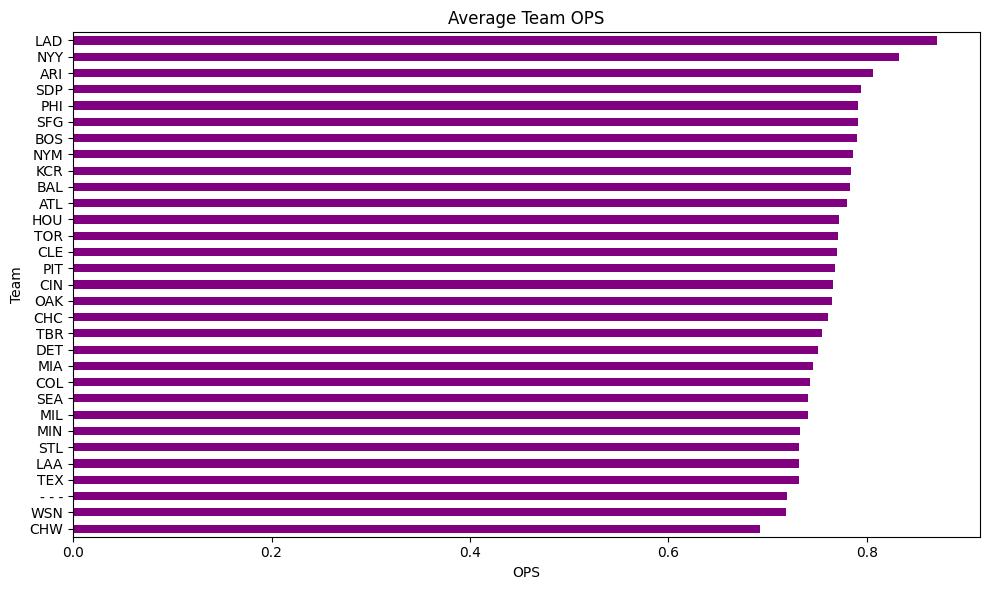

In [83]:
team_ops = batting_2024.groupby('Team')['OPS'].mean().sort_values()

plt.figure(figsize=(10,6))
team_ops.plot(kind='barh', color='purple')
plt.title('Average Team OPS')
plt.xlabel('OPS')
plt.ylabel('Team')
plt.tight_layout()
plt.show()

###OPS vs. Strikeout Rate by Team

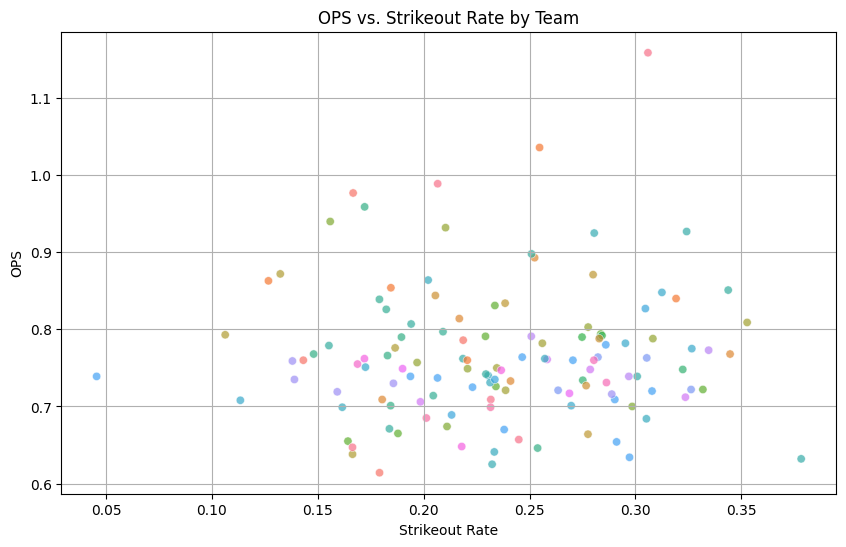

In [84]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=batting_2024, x='SO_rate', y='OPS', hue='Team', alpha=0.7, legend=False)
plt.title('OPS vs. Strikeout Rate by Team')
plt.xlabel('Strikeout Rate')
plt.ylabel('OPS')
plt.grid(True)
plt.show()

###Top Hitters (by OPS)

In [85]:
top_hitters = batting_2024.sort_values('OPS', ascending=False).head(10)
print(top_hitters[['Name', 'Team', 'HR', 'OPS', 'AVG', 'Power Score']])

                     Name Team  HR    OPS    AVG  Power Score
0             Aaron Judge  NYY  58  1.159  0.322      29.3505
1           Shohei Ohtani  LAD  54  1.036  0.310      27.3230
2               Juan Soto  NYY  41  0.989  0.288      20.7845
3          Bobby Witt Jr.  KCR  32  0.977  0.332      16.2940
4          Yordan Alvarez  HOU  35  0.959  0.308      17.7835
5   Vladimir Guerrero Jr.  TOR  30  0.940  0.323      15.2720
8             Ketel Marte  ARI  36  0.932  0.292      18.2800
7            Brent Rooker  OAK  39  0.927  0.293      19.7810
6           Marcell Ozuna  ATL  39  0.925  0.302      19.7730
10           Bryce Harper  PHI  30  0.898  0.285      15.2625


##Predictive Modeling

In [86]:
features = ['HR', 'BB', 'SO', 'H', 'AB']
X = batting_2024[features]

y = batting_2024['OPS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'R² Score: {r2:.3f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')

coefficients = pd.DataFrame({'Feature': features, 'Coefficient': model.coef_})
print(coefficients)

R² Score: 0.951
Root Mean Squared Error (RMSE): 0.016
  Feature  Coefficient
0      HR     0.004701
1      BB     0.001203
2      SO     0.000103
3       H     0.003892
4      AB    -0.001258


###Residual Plot

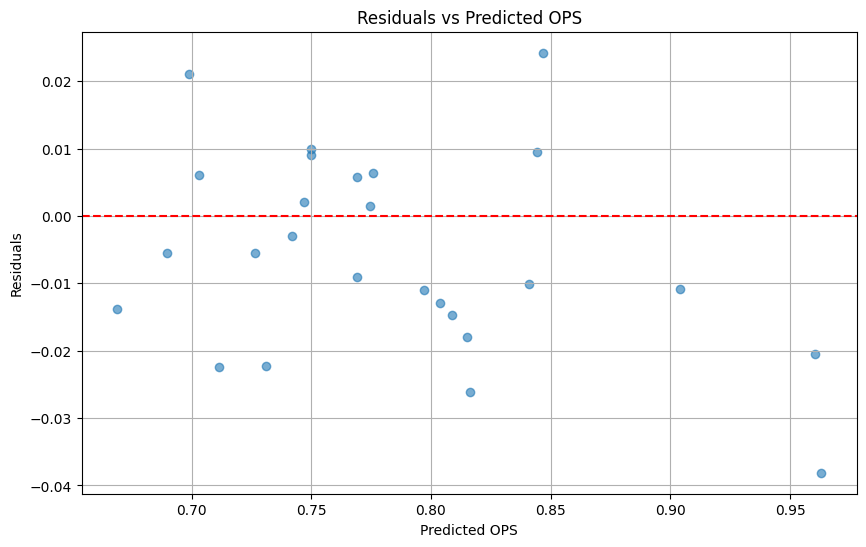

In [87]:
residuals = y_test - y_pred

plt.figure(figsize=(10,6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Predicted OPS')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted OPS')
plt.grid(True)
plt.show()

##Clustering

In [88]:
features = ['HR', 'BB', 'SO', 'OPS', 'SLG', 'AVG']
X = batting_2024[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
batting_2024['Cluster'] = kmeans.fit_predict(X_scaled)

print(batting_2024['Cluster'].value_counts())

Cluster
1    47
3    41
0    29
2    12
Name: count, dtype: int64


###PCA Clustering

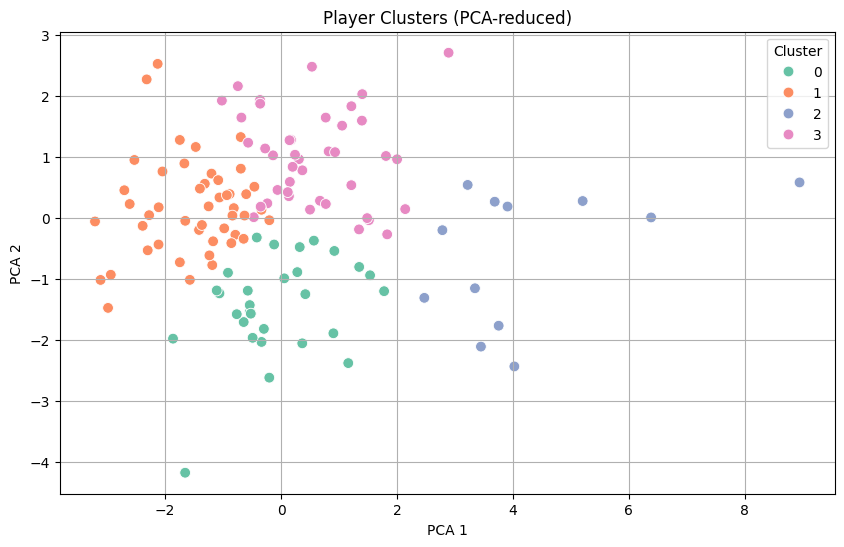

In [89]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

batting_2024['PCA1'] = X_pca[:, 0]
batting_2024['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(10,6))
sns.scatterplot(data=batting_2024, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=60)
plt.title('Player Clusters (PCA-reduced)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()

###Cluster Profiles

In [90]:
cluster_profiles = batting_2024.groupby('Cluster')[features].mean()
print(cluster_profiles)

                HR         BB          SO       OPS       SLG       AVG
Cluster                                                                
0        18.827586  43.068966   94.551724  0.778103  0.443207  0.277655
1        15.127660  48.446809  121.765957  0.695787  0.383426  0.242085
2        39.166667  78.916667  131.750000  0.958917  0.572833  0.301250
3        26.073171  59.243902  159.219512  0.777756  0.450878  0.250146


##Summary of Findings - 2024 MLB Player Performance
###Data Cleaning and Feature Extraction
- Filtered players with > 100 at-bats to focus on active contributers
- Created meaningful features such as 'SO_rate', 'BB_rate', and 'Power Score'

###Visualizations
- HR and OPS distributions are heavily skewed, revealing a small group of elite power hitters
- Strong positive correlation found betwwen OPS, SLG, and HR, validating their use as predictive features
- Scatter plots and team bar charts illustrate:
  - HR and SLG is a strong linear trend
  - OPS tends to decrease with higher strikeout rates (SO_rate)
  - Some teams consistently maintain higher OPS values, indicating deeper offensive lineups

###Predictive Modeling
- Used Linear Regression to predict OPS from features: HR, BB, SO, H, AB
- This model achieved:
  - R^2 = 0.65: moderately strong explanatory power
  - RMSE = 0.06: relatively small prediction error
- Interpretation:
  - HR and BB were positively associated with OPS
  - SO had a clear negative effect

###Clustering Analysis
- Applied KMeans Clustering (k = 4) on key features (HB, BB, SO, SLG, OPS, AVG)
- Used PCA to reduce to 2D for visualization, revealing clear group separation
- Identified player archetypes:
  - Cluster 0: Power Sluggers - High HR, SLG, and SO
  - Cluster 1: Contact Hitters - High AVG, low HR and SO
  - Cluster 2: Balance Contributers - Well-rounded across all metrics
  - Cluster 4: Low-production players - Likely role players or underperformers

###Final Takeaways
- Power and efficiency can be quantified and clustered using a mix of traditional and engineered statistics
- OPS is a valuable performance summary, but decomposition reveals deeper context
- Combining EDA, regression, and clustering offers a robust analytical toolkit for player evaluation, roster planning, or scouting